In [2]:
import pandas as pd
import numpy as np
import csv
from datetime import datetime, timedelta
from sklearn.datasets import make_regression
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib
import itertools
from pylab import rcParams
import pickle
import warnings
warnings.filterwarnings("ignore")

/Users/vaishrohan/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
mapping = {}
for i in range(1,7):
    file_path = 'low_freq/house_' + str(i) + '/labels.dat'
    mapping[i] = {}
    with open(file_path) as file:
        for line in file:
            mapping[i][int(line.split(' ')[0].strip())] = line.split(' ')[1].strip() + '_' + line.split(' ')[0].strip()
print(mapping[1])

{1: 'mains_1', 2: 'mains_2', 3: 'oven_3', 4: 'oven_4', 5: 'refrigerator_5', 6: 'dishwaser_6', 7: 'kitchen_outlets_7', 8: 'kitchen_outlets_8', 9: 'lighting_9', 10: 'washer_dryer_10', 11: 'microwave_11', 12: 'bathroom_gfi_12', 13: 'electric_heat_13', 14: 'stove_14', 15: 'kitchen_outlets_15', 16: 'kitchen_outlets_16', 17: 'lighting_17', 18: 'lighting_18', 19: 'washer_dryer_19', 20: 'washer_dryer_20'}


In [4]:
df = {}
for i in range(1,7):
    file_path = 'low_freq/house_' + str(i) + '/channel_' + str(i) + '.dat'
    df[i] = pd.read_csv(file_path , sep = ' ', names = ['TimeStamp', mapping[i][1]], dtype = {'TimeStamp': 'int64', mapping[i][1]:'float64'})
    for j in range(2, len(mapping[i])+1):
        curr_file_path =  'low_freq/house_' + str(i) + '/channel_' + str(j) + '.dat'
        curr = pd.read_csv(curr_file_path , sep = ' ', names = ['TimeStamp', mapping[i][j]], dtype = {'TimeStamp': 'int64', mapping[i][j]:'float64'})
        df[i] = pd.merge(df[i], curr, how='inner', on='TimeStamp')
    df[i]['TimeStamp'] = df[i]['TimeStamp'].astype("datetime64[s]")
        

In [5]:
for i in range(1,7):
    for j, row in df[i].iterrows():
        df[i].at[j,'Year'] = row[0].year
        df[i].at[j,'Month'] = row[0].month
        df[i].at[j,'Day'] = row[0].day
        df[i].at[j,'Hour'] = row[0].hour
        df[i].at[j,'Minute'] = row[0].minute
        df[i].at[j,'Seconds'] = row[0].second
        if row[0].weekday() in [5,6] :
            df[i].at[j, 'Holiday'] = 1
        else:
            df[i].at[j, 'Holiday'] = 0
        if row[0].hour in [0,1,2,3,4,5,6,7,20,21,22,23]:
            df[i].at[j, 'Peak Hour'] = 1
        else:
            df[i].at[j, 'Peak Hour'] = 0
        


In [27]:
train_size = (80 *len(df[1]))/100
display(df[1][train_size:])

,TimeStamp,mains_1,mains_2,oven_3,oven_4,refrigerator_5,dishwaser_6,kitchen_outlets_7,kitchen_outlets_8,lighting_9,...,washer_dryer_19,washer_dryer_20,Year,Month,Day,Hour,Minute,Seconds,Holiday,Peak Hour
325398,2011-05-11 13:20:52,67.50,38.57,0.0,0.0,7.0,0.0,20.0,21.0,2.0,...,0.0,0.0,2011.0,5.0,11.0,13.0,20.0,52.0,0.0,0.0
325399,2011-05-11 13:20:55,67.76,38.64,0.0,0.0,6.0,0.0,24.0,21.0,2.0,...,0.0,0.0,2011.0,5.0,11.0,13.0,20.0,55.0,0.0,0.0
325400,2011-05-11 13:20:58,67.30,38.45,0.0,0.0,6.0,0.0,21.0,21.0,2.0,...,0.0,0.0,2011.0,5.0,11.0,13.0,20.0,58.0,0.0,0.0
325401,2011-05-11 13:21:02,67.88,38.62,0.0,0.0,6.0,0.0,20.0,21.0,2.0,...,0.0,0.0,2011.0,5.0,11.0,13.0,21.0,2.0,0.0,0.0
325402,2011-05-11 13:21:05,67.47,38.76,0.0,0.0,7.0,0.0,20.0,21.0,2.0,...,0.0,0.0,2011.0,5.0,11.0,13.0,21.0,5.0,0.0,0.0
325403,2011-05-11 13:21:09,67.87,38.67,0.0,0.0,7.0,0.0,20.0,21.0,2.0,...,0.0,0.0,2011.0,5.0,11.0,13.0,21.0,9.0,0.0,0.0
325404,2011-05-11 13:21:18,67.13,38.57,0.0,0.0,7.0,0.0,20.0,21.0,2.0,...,0.0,0.0,2011.0,5.0,11.0,13.0,21.0,18.0,0.0,0.0
325405,2011-05-11 13:21:21,67.71,38.34,0.0,0.0,7.0,0.0,20.0,21.0,2.0,...,0.0,0.0,2011.0,5.0,11.0,13.0,21.0,21.0,0.0,0.0
325406,2011-05-11 13:21:24,67.34,38.70,0.0,0.0,6.0,0.0,20.0,21.0,2.0,...,0.0,0.0,2011.0,5.0,11.0,13.0,21.0,24.0,0.0,0.0
325407,2011-05-11 13:21:28,67.74,38.69,0.0,0.0,6.0,0.0,22.0,21.0,2.0,...,0.0,0.0,2011.0,5.0,11.0,13.0,21.0,28.0,0.0,0.0


In [28]:
result = {}
for key , target in mapping[1].iteritems():
    features = []
    for key, value in mapping[1].iteritems():
        if value != target:
            features.append(value)
    features.append('Day')
    features.append('Hour')
    features.append('Minute')
    features.append('Seconds')
    features.append('Holiday')
    features.append('Peak Hour')
    train_size = (80 *len(df[1]))/100
    x_train = df[1][features][:train_size]
    y_train = df[1]['oven_3'][:train_size]
    x_test = df[1][features][train_size:]
    y_test = df[1]['oven_3'][train_size:]

    regr = RandomForestRegressor(max_depth=2, random_state=0)
    regr.fit(x_train, y_train)
    y_pred_r = regr.predict(x_test)
    result[target] = []
    result[target].append(y_pred_r)
    print("Mean absolute error LR: %.9f"
          % mean_absolute_error(y_test,y_pred_r))
    result[target].append(mean_absolute_error(y_test,y_pred_r))
#     display(y_pred_r)
#     display(y_test)

Mean absolute error LR: 0.225032229
Mean absolute error LR: 0.225032229
Mean absolute error LR: 0.378836560
Mean absolute error LR: 0.225032229
Mean absolute error LR: 0.225032229
Mean absolute error LR: 0.225032229
Mean absolute error LR: 0.225032229
Mean absolute error LR: 0.225032229
Mean absolute error LR: 0.225032229
Mean absolute error LR: 0.225032229
Mean absolute error LR: 0.225032229
Mean absolute error LR: 0.225032229
Mean absolute error LR: 0.225032229
Mean absolute error LR: 0.225032229
Mean absolute error LR: 0.225032229
Mean absolute error LR: 0.225032229
Mean absolute error LR: 0.225032229
Mean absolute error LR: 0.225032229
Mean absolute error LR: 0.225032229
Mean absolute error LR: 0.225032229


In [32]:
display(result['oven_3'][1])

0.3788365603985954

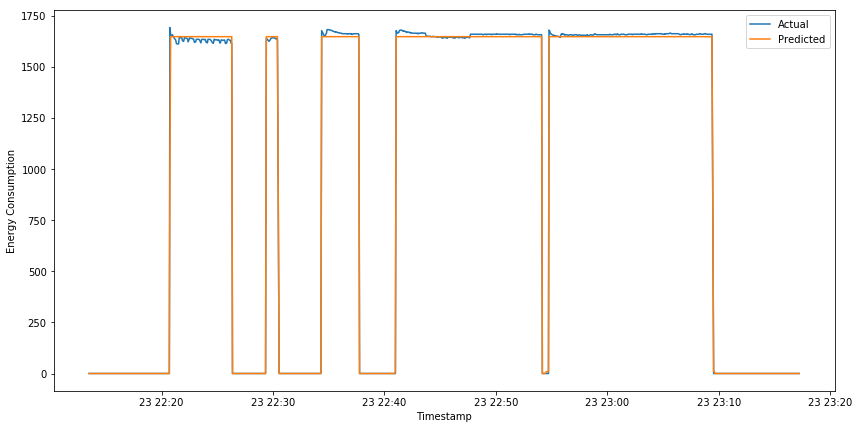

In [7]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size
timeline = df[1]['TimeStamp'][train_size+62400:train_size+63400]
plt.plot(timeline, y_test[62400:63400], label="Actual")
plt.plot(timeline, y_pred_r[62400:63400], label="Predicted")
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()